In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam




In [2]:

train_dir = r"C:\Users\dell\Desktop\Fine Tuning\training_set"
test_dir = r"C:\Users\dell\Desktop\Fine Tuning\test_set"



In [3]:
# Step 2: Data Preprocessing & Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)



In [4]:
# Load Train Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [5]:

# Load Test Data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)



Found 2023 images belonging to 2 classes.


In [6]:
# Step 3: Load Pretrained VGG16 Model (Before Fine-Tuning)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freezing all layers initially



In [7]:

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=x)



In [8]:

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])



In [9]:

history_before = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)



Epoch 1/5
201/201 [==============================] - 1792s 9s/step - loss: 0.4434 - accuracy: 0.7909 - val_loss: 0.3022 - val_accuracy: 0.8776
Epoch 2/5
201/201 [==============================] - 1263s 6s/step - loss: 0.3372 - accuracy: 0.8523 - val_loss: 0.2717 - val_accuracy: 0.8844
Epoch 3/5
201/201 [==============================] - 1313s 7s/step - loss: 0.3013 - accuracy: 0.8691 - val_loss: 0.2801 - val_accuracy: 0.8832
Epoch 4/5
201/201 [==============================] - 1194s 6s/step - loss: 0.2831 - accuracy: 0.8752 - val_loss: 0.2468 - val_accuracy: 0.8982
Epoch 5/5
201/201 [==============================] - 1189s 6s/step - loss: 0.2686 - accuracy: 0.8860 - val_loss: 0.2458 - val_accuracy: 0.8888


In [10]:

test_loss_before, test_acc_before = model.evaluate(test_generator)
print(f"Test Accuracy Before Fine-Tuning: {test_acc_before * 100:.2f}%")


64/64 [==============================] - 306s 5s/step - loss: 0.1825 - accuracy: 0.9179
Test Accuracy Before Fine-Tuning: 91.79%


In [11]:

for layer in base_model.layers[:15]:
    layer.trainable = False  
for layer in base_model.layers[15:]:
    layer.trainable = True 


model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


history_after = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


test_loss_after, test_acc_after = model.evaluate(test_generator)
print(f"Test Accuracy After Fine-Tuning: {test_acc_after * 100:.2f}%")



64/64 [==============================] - 357s 6s/step - loss: 0.1394 - accuracy: 0.9392
Test Accuracy After Fine-Tuning: 93.92%


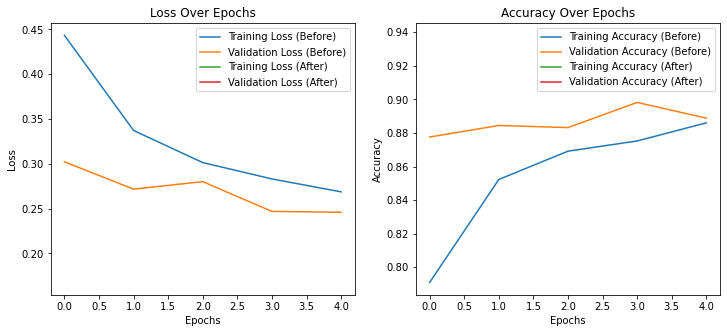

In [12]:

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history_before.history['loss'], label='Training Loss (Before)')
plt.plot(history_before.history['val_loss'], label='Validation Loss (Before)')
plt.plot(history_after.history['loss'], label='Training Loss (After)')
plt.plot(history_after.history['val_loss'], label='Validation Loss (After)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_before.history['accuracy'], label='Training Accuracy (Before)')
plt.plot(history_before.history['val_accuracy'], label='Validation Accuracy (Before)')
plt.plot(history_after.history['accuracy'], label='Training Accuracy (After)')
plt.plot(history_after.history['val_accuracy'], label='Validation Accuracy (After)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

# Thank You